## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Setting up data

In [2]:
#read in data
data = pd.read_csv('../data/train_clean.csv', index_col='respondent_id')

In [3]:
# make a new feature h1n1_all for participants who had both h1n1_concern and h1n1_knowledge
data['h1n1_all'] = data['h1n1_concern'] * data['h1n1_knowledge']

# make a new feature h1n1_all for participants who responded yes to all the behavior #questions
behaviour_columns = [column for column in list(data.columns) if 'behavioral' in column]

data['behavioral_all'] = 1

for column in behaviour_columns:
    data['behavioral_all'] = data['behavioral_all'] * data[column]

In [4]:
# make a new feature opinion_all for participants based on their opinion scores to the opinion questions
opinion_columns = [column for column in list(data.columns) if 'opinion' in column]

data['opinion_all'] = 1

for column in opinion_columns:
    data['opinion_all'] = data['opinion_all'] * data[column]

In [5]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,h1n1_all,behavioral_all,opinion_all
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Non-MSA,0.0,0.0,no_response,no_response,0,0,0.0,0.0,24.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,6.0,0.0,2560.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,no_response,...,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1.0,0.0,24.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,"MSA, Principle City",0.0,0.0,no_response,no_response,0,1,1.0,0.0,900.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,2.0,0.0,216.0


In [10]:
cols = list(data.select_dtypes('object').columns)

In [12]:
data = pd.get_dummies(data=data, columns=cols, drop_first=True)

In [16]:
#Switching positive and negative classes
data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts(normalize=True)

1    0.534392
0    0.465608
Name: seasonal_vaccine, dtype: float64

In [17]:
#Switching positive and negative classes
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts(normalize=True)

1    0.787546
0    0.212454
Name: h1n1_vaccine, dtype: float64

In [18]:
#Set up variables
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y_szn = data['seasonal_vaccine']
y_h1n1 = data['h1n1_vaccine']

In [24]:
#Setting up pipelines and parameters
pipe_log = Pipeline([
    ('log', LogisticRegression(max_iter=5000))
])

log_par = {
    'log__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'log__solver': ['liblinear', 'lbfgs'],
    'log__penalty': ['l1', 'l2'],
    'log__class_weight': ['balanced']
}

scoring = ['roc_auc', 'recall', 'precision', 'balanced_accuracy']

### Models for H1N1

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y_h1n1, random_state=42, stratify = y_h1n1)

In [29]:
gs_recall = GridSearchCV(pipe_log, param_grid = log_par, scoring = scoring[1], n_jobs = -1, cv = 5)

In [30]:
gs_recall.fit(X_train, y_train)

C:\Users\fusio\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.79968304        nan 0.80057052 0.79936609 0.80019017        nan
 0.80019017 0.80126783 0.80126783        nan 0.79974643 0.79746434
 0.80348653        nan 0.80190174 0.79980983 0.79968304        nan
 0.79270998 0.798542   0.7037084         nan 0.75980983 0.77832013]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('log',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'log__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'log__class_weight': ['balanced'],
                         'log__penalty': ['l1', 'l2'],
                         'log__solver': ['liblinear', 'lbfgs']},
             scoring='recall')

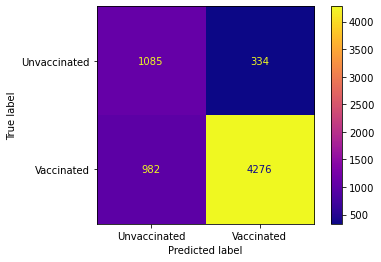

In [41]:
plot_confusion_matrix(gs_recall, X_test, y_test, display_labels=['Unvaccinated', 'Vaccinated'], cmap = 'plasma');

In [139]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, accuracy_score

In [57]:
y_pred = gs_recall.predict(X_test)

In [71]:
y_pred = pd.DataFrame(y_pred)
y_pred['respondent_id'] = X_test.index
y_pred.set_index('respondent_id', inplace=True)
y_pred

,0
respondent_id,
18204,1
22436,1
16986,1
12359,0
18602,0
...,...
6456,1
18269,1
20563,1


In [73]:
y_true = y_pred.join(y_h1n1, on='respondent_id')

In [81]:
balanced_accuracy_score(y_true['h1n1_vaccine'], y_pred)

0.7889299730790438

In [84]:
roc_auc_score(y_true['h1n1_vaccine'], y_pred)

0.7889299730790438

In [83]:
precision_score(y_true['h1n1_vaccine'], y_pred)

0.9275488069414317

In [82]:
recall_score(y_true['h1n1_vaccine'], y_pred)

0.8132369722327881

### Adding Predicted H1N1 into Data

In [99]:
preds = logr.predict(data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']))

In [101]:
X2 = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

In [102]:
X2['h1n1_vaccine'] = preds

### Models for Seasonal Flu

In [110]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2.drop(columns='h1n1_vaccine'), y_szn, random_state=42, stratify = y_szn)

In [111]:
gs_recall_2 = GridSearchCV(pipe_log, param_grid = log_par, scoring = scoring[1], n_jobs = -1, cv = 5)

In [112]:
gs_recall_2.fit(X_train2, y_train2)

C:\Users\fusio\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.78335139        nan 0.78335117 0.78325785 0.78325776        nan
 0.78325789 0.7788672  0.78409862        nan 0.7829776  0.78129584
 0.78503315        nan 0.77970801 0.78148324 0.7671895         nan
 0.76597476 0.78054887 0.65031678        nan 0.73645318 0.76504097]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('log',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'log__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'log__class_weight': ['balanced'],
                         'log__penalty': ['l1', 'l2'],
                         'log__solver': ['liblinear', 'lbfgs']},
             scoring='recall')

In [113]:
gs_recall_2.score(X_train2, y_train2), gs_recall_2.score(X_test2, y_test2)

(0.7865284005979073, 0.7993273542600897)

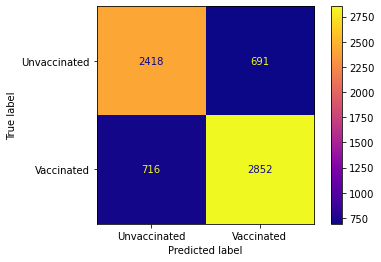

In [114]:
plot_confusion_matrix(gs_recall_2, X_test2, y_test2, display_labels=['Unvaccinated', 'Vaccinated'], cmap = 'plasma');

In [115]:
gs_recall_2.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__penalty': 'l1',
 'log__solver': 'liblinear'}

In [116]:
logr2 = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='liblinear')

In [120]:
logr2.fit(X_train2, y_train2)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [128]:
szn_preds = logr2.predict(X_test2)

In [130]:
szn_preds = pd.DataFrame(szn_preds)
szn_preds['respondent_id'] = X_test2.index
szn_preds.set_index('respondent_id', inplace=True)
szn_preds

,0
respondent_id,
8555,1
23697,1
1400,1
2965,0
20367,0
...,...
20629,1
20976,0
13930,0


In [131]:
szn_true = szn_preds.join(y_szn, on='respondent_id')

In [134]:
balanced_accuracy_score(szn_true['seasonal_vaccine'], szn_preds)

0.7879327808604268

In [136]:
roc_auc_score(szn_true['seasonal_vaccine'], szn_preds)

0.787932780860427

In [137]:
precision_score(szn_true['seasonal_vaccine'], szn_preds)

0.8044030482641829

In [138]:
recall_score(szn_true['seasonal_vaccine'], szn_preds)

0.7987668161434978

In [140]:
accuracy_score(szn_true['seasonal_vaccine'], szn_preds)

0.7886775497978133

In [141]:
accuracy_score(y_true['h1n1_vaccine'], y_pred)

0.8029054964804553